In [2]:
import obspy.geodetics.base as geod
import numpy.random as random
import numpy as np
import sys
from scipy import signal
from scipy.special import j0
from scipy.special import j1

from matplotlib import pyplot as plt
import pickle
[lats,lons]=pickle.load(open("stations.pickle","rb"))
dist_ref = 100

In [4]:
stnum = len(lons)
dx = np.zeros(stnum)
dy = np.zeros(stnum)
TT = np.zeros(stnum)
d   = np.zeros(stnum, dtype=complex)
w = np.zeros(stnum)
st_az    = np.zeros(stnum)
dist = np.zeros(stnum)

freq = 0.15
ω = freq*2*np.pi

evlon = 138
evlat = 36 

for i in range(len(lons)):
    [dist[i],st_az[i],baz] = geod.gps2dist_azimuth(lats.mean(),lons.mean(),lats[i],lons[i])
    dx[i] = np.sin(st_az[i]*np.pi/180.)*dist[i]*1E-3
    dy[i] = np.cos(st_az[i]*np.pi/180.)*dist[i]*1E-3 
    dist[i] = geod.gps2dist_azimuth(evlat,evlon,lats[i],lons[i])[0]*1E-3


# Calc. of station separation distance

In [5]:
lon0,lat0,dist0 = lons[dist<dist_ref],lats[dist<dist_ref],dist[dist<dist_ref]
dist_pair=np.zeros((len(lon0)-1)*len(lon0)//2)
num = 0
for i in range(len(lon0)):
    for j in range(i+1,len(lon0)):
        dist_pair[num] = geod.gps2dist_azimuth(lat0[i],lon0[i],lat0[j],lon0[j])[0]*1E-3
        num += 1

# Mesasurements of slowness by beamforming, SPAC, and FJ method methods

* Frequency is 0.15 Hz
* Slowness is 0.3 s/km
* Synthetic cross spectrum is $J_0(k\Delta) + n$. The noise is 3%.

(0.1, 0.5)

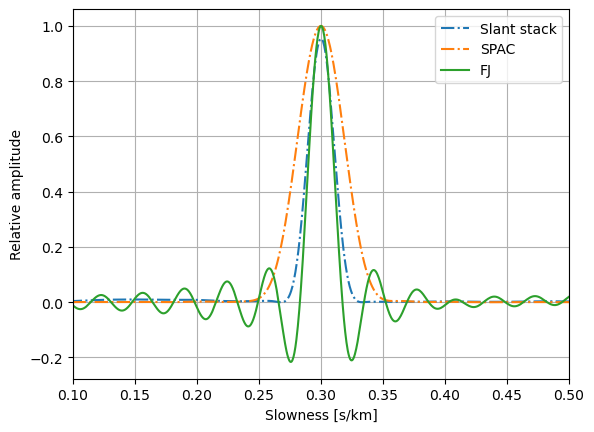

In [11]:
dist_pair.sort()

f_ref = 0.15 # Freuqnecy
p0 = 0.3 #Slowness
k0 = 2*np.pi*f_ref*p0
y0 = j0(k0*dist_pair)+np.random.randn(len(dist_pair))*0.03 #Synthitic 
cp_range = np.arange(2.,10.,0.005)

#SPAC
vr0 = np.zeros(len(cp_range))
α0 = np.zeros(len(cp_range))
num = 0
y2 = y0@y0
for cp in cp_range:
    k1 = 2*np.pi*f_ref/cp
    m1 = j0(k1*dist_pair)
    m2 = m1@m1
    cross = m1@y0
    vr0[num] = y2-cross**2/m2
    α0[num] = cross/m2
    num += 1
vr0 /= y2

#Slant stack
vr1 = np.zeros(len(cp_range))
α1 = np.zeros(len(cp_range))
num = 0
w = np.sqrt(dist_pair.copy())
y2 = y0@(y0*w)
for cp in cp_range:
    k1 = 2*np.pi*f_ref/cp
    m1 = np.cos(k1*dist_pair)
    cross = (m1@(y0*w))**2
    m1 = np.sin(k1*dist_pair)
    cross += (m1@(y0*w))**2
    α1[num] = cross
    num += 1
vr1 /= y2

#FJ
FJ = np.zeros(len(cp_range))

num = 0
rn = np.zeros(len(dist_pair)+2)
rn[1:-1] = dist_pair
rn[-1] = rn[-2]
w = (rn[2:]**2+2*rn[1:-1]*(rn[2:]-rn[0:-2])-rn[0:-2]**2)/8.
for cp in cp_range:
    k1 = 2*np.pi*f_ref/cp
    m1 = j0(k1*dist_pair)
    
    FJ[num] =   m1@(y0*w) *(2*np.pi*f_ref)**2*cp**-1 #*np.cos(np.pi*dist_pair[:-1]/400))
    num += 1

plt.plot(1./cp_range,(1-vr0),"-.",label="Slant stack")
plt.plot(1./cp_range,α1/max(α1),"-.",label="SPAC")
plt.plot(1./cp_range,FJ/max(FJ),label="FJ")
plt.grid()
plt.legend()
plt.xlabel("Slowness [s/km]")
plt.ylabel("Relative amplitude")
plt.xlim(0.1,0.5)


# Histogram of estimation errors of beamforming, SPAC and FJ methods


In [15]:
dist_pair.sort()
loop = 1000
f_ref = 0.15
p0 = 0.3
k0 = 2*np.pi*f_ref*p0
p_range = np.arange(p0-0.001,p0+0.001,0.000001)
dp0, dp1, dp2, dp3,dp4 = [np.zeros(loop) for _ in range(5)]

for smpl in range(loop):
    y0 = j0(k0*dist_pair) + np.random.randn(len(dist_pair))*0.03

    #SPAC
    vr0 = np.zeros(len(p_range))
    α0 = np.zeros(len(p_range))
    num = 0
    y2 = y0@y0
    for p in p_range:
        k1 = 2*np.pi*f_ref*p
        m1 = j0(k1*dist_pair)
        m2 = m1@m1
        cross = m1@y0
        vr0[num] = y2-cross**2/m2
        α0[num] = cross/m2
        num += 1
    vr0 /= y2

    #Beamforming
    vr1 = np.zeros(len(p_range))
    α1 = np.zeros(len(p_range))
    num = 0
    w = np.sqrt(dist_pair.copy())
    y2 = y0@(y0*w)
    for p in p_range:
        k1 = 2*np.pi*f_ref*p
        m1 = np.cos(k1*dist_pair)
        cross = (m1@(y0*w))**2
        m1 = np.sin(k1*dist_pair)
        cross += (m1@(y0*w))**2
        #vr1[num] = y2-cross**2/m2
        α1[num] = cross
        num += 1

    vr2 = np.zeros(len(p_range))
    FJ = np.zeros(len(p_range))
    FJ2 = np.zeros(len(p_range))

    dr = dist_pair[1:]-dist_pair[0:-1]
    rn = np.zeros(len(dist_pair)+2)
    rn[1:-1] = dist_pair
    rn[-1] = rn[-2]
    w = (rn[2:]**2+2*rn[1:-1]*(rn[2:]-rn[0:-2])-rn[0:-2]**2)/8.
    num = 0
    y2 = y0@(y0*w)
    for p in p_range:
        k1 = 2*np.pi*f_ref*p
        m1 = j0(k1*dist_pair)
        m2 = m1@(m1*w)
        FJ[num] =  m1@(y0*w) *(2*np.pi*f_ref)**2*p 
        FJ2[num] =  m1@(y0*w)*(2*np.pi*f_ref)**2*p**3 

        vr2[num] = y2 -(m1@(y0*w))**2/m2
        num += 1
        
    if smpl%1000 == 0: print(smpl)

    dp0[smpl] = (p_range[np.argmax(1-vr0)]-p0)/p0*1E2
    dp1[smpl] = (p_range[np.argmax(α1)]-p0)/p0*1E2
    dp2[smpl] = (p_range[np.argmax(FJ)]-p0)/p0*1E2
    dp3[smpl] = (p_range[np.argmax(1-vr2)]-p0)/p0*1E2
    dp4[smpl] = (p_range[np.argmax(FJ2)]-p0)/p0*1E2


0


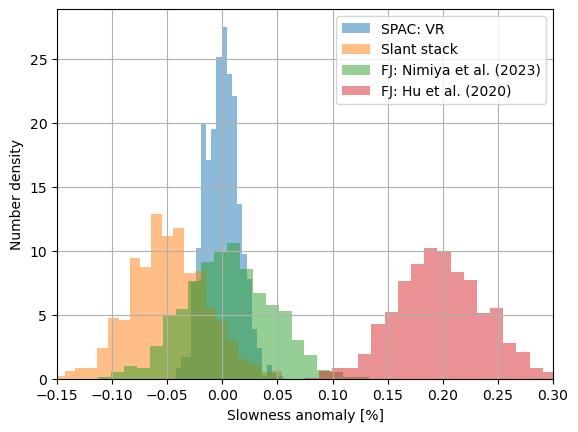

In [16]:
nbins = 21
plt.hist(dp0,alpha=0.5,bins=nbins,label="SPAC: VR",density=True)
plt.hist(dp1,alpha=0.5,bins=nbins,label="Slant stack",density=True)
plt.hist(dp2,alpha=0.5,bins=nbins,label="FJ: Nimiya et al. (2023)",density=True)
plt.hist(dp4,alpha=0.5,bins=nbins,label="FJ: Hu et al. (2020)",density=True)

plt.xlabel("Slowness anomaly [%]")
plt.ylabel("Number density")
plt.xlim(-0.15,0.3)
plt.legend()
plt.grid()
plt.show()